# 6. Tremors within seismic clusters

We here compare the detection of tremors made in Husker et al. (2018) with the
detection rate of the cluster to identify which cluster contains tremors.

In [1]:
import os
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm import tqdm

import figures
from scatterings import ScatteringDatabase, to_xarray

## Global parameters

In [2]:
NETWORK = "network_1"
POOLING = "max"
REDUCTION = "fastica_20"
CLUSTERING = "kmeans_15"

SUFFIX = f"{REDUCTION}_{CLUSTERING}"
DIRPATH_FIGURES = f"./paper/{POOLING}"
FILEPATH_DATABASE = "./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl"
FILEPATH_NETWORK = f"./model/{NETWORK}.pkl"
FILEPATH_SCATTERINGS = f"./out/{NETWORK}_{POOLING}.pkl"
FILEPATH_CLUSTERS = f"./out/{NETWORK}_{POOLING}_{SUFFIX}.pkl"
FILEPATH_CATALOG = "./data/catalogs/tremors_S1_husker.csv"

# Create the directory for the figures if it does not exist.
os.makedirs(DIRPATH_FIGURES, exist_ok=True)

# Print out files
print(f"Filepath database: {FILEPATH_DATABASE}")
print(f"Filepath network: {FILEPATH_NETWORK}")
print(f"Filepath scatterings: {FILEPATH_SCATTERINGS}")
print(f"Filepath clusters: {FILEPATH_CLUSTERS}")
print(f"Filepath catalog: {FILEPATH_CATALOG}")
print(f"Dirpath figures: {DIRPATH_FIGURES}")

Filepath database: ./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl
Filepath network: ./model/network_1.pkl
Filepath scatterings: ./out/network_1_max.pkl
Filepath clusters: ./out/network_1_max_fastica_20_kmeans_15.pkl
Filepath catalog: ./data/catalogs/tremors_S1_husker.csv
Dirpath figures: ./paper/max


## Load previous runs and database

In [3]:
# Scattering database
scatterings = ScatteringDatabase(
    filepath_database=FILEPATH_DATABASE,
    filepath_scatterings=FILEPATH_SCATTERINGS,
    filepath_model=FILEPATH_NETWORK,
)
print(f"Scattering coefficients loaded from {FILEPATH_SCATTERINGS}")

# Clusters
data = pickle.load(open(FILEPATH_CLUSTERS, "rb"))
print(f"Clusters loaded from {FILEPATH_CLUSTERS}")

Scattering coefficients loaded from ./out/network_1_max.pkl
Clusters loaded from ./out/network_1_max_fastica_20_kmeans_15.pkl


## Load tremor catalog from Husker et al. (2018)

This cell loads the tremor catalog from Husker et al. (2018) and converts it to
a pandas dataframe. The catalog is available from the publication website.

In [4]:
# Load catalog
catalog = pd.read_fwf(
    FILEPATH_CATALOG,
    names=["year.jday", "hour_start", "hour_stop", "duration (hours)"],
    skiprows=15,
    dtype=str,
)

# Convert starttime to datetime
catalog["starttime"] = pd.to_datetime(
    catalog["year.jday"], format="%Y.%j"
) + pd.to_timedelta(catalog["hour_start"].astype(float), unit="h")

# Convert endtime to datetime
catalog["endtime"] = pd.to_datetime(
    catalog["year.jday"], format="%Y.%j"
) + pd.to_timedelta(catalog["hour_stop"].astype(float), unit="h")

# Convert duration to timedelta
catalog["duration"] = pd.to_timedelta(
    catalog["duration (hours)"].astype(float), unit="h"
)

# Drop unnecessary columns
catalog = catalog.set_index("starttime")
catalog = catalog[["endtime", "duration"]]

# Print 
print(f"Tremor catalog loaded from {FILEPATH_CATALOG}")
catalog.head()

Tremor catalog loaded from ./data/catalogs/tremors_S1_husker.csv


,endtime,duration
starttime,,
2009-02-25 20:15:00,2009-02-25 20:29:24.000000000,0 days 00:14:24
2009-02-28 22:57:54,2009-02-28 23:15:00.000000000,0 days 00:17:05.999999999
2009-03-11 20:01:30,2009-03-11 20:09:36.000000000,0 days 00:08:06
2009-03-12 13:39:54,2009-03-12 13:48:00.000000000,0 days 00:08:06
2009-03-12 14:04:12,2009-03-12 14:33:53.999999999,0 days 00:29:42


## Put catalog on same time scale than clusters

In [30]:
TOLERANCE = np.timedelta64(50, "s")

# Initialize tremor catalog as if it was a cluster
catalog_as_cluster = data.clusters.isel(cluster=0).copy() 
catalog_as_cluster.values = np.full_like(catalog_as_cluster.values, False, dtype=bool)

# Loop over catalog to find windows with tremors
for index, row in tqdm(catalog.iterrows(), total=len(catalog), desc="Theoretical cluster of tremors"):

    # Get actual tremor starttime
    starttime = index.to_datetime64()
    endtime = row.endtime.to_datetime64()

    # Get corresponding detection indexes and set them to True
    start_id = min(catalog_as_cluster.time.searchsorted(starttime) - 1, catalog_as_cluster.shape[0] - 2)
    end_id = min(catalog_as_cluster.time.searchsorted(endtime) - 1, catalog_as_cluster.shape[0] - 1)

    # Exclude tremors that start too close of the next window
    if np.abs(catalog_as_cluster.time[start_id + 1] - starttime) < TOLERANCE:
        start_id += 1

    # Exclude tremors that start too close of the next window
    if np.abs(catalog_as_cluster.time[end_id] - endtime) < TOLERANCE:
        end_id -= 1

    # Set tremor windows to True
    catalog_as_cluster[start_id:end_id + 1] = True

Theoretical cluster of tremors: 100%|██████████| 5945/5945 [00:13<00:00, 441.84it/s]


## Get distribution of tremor per clusters

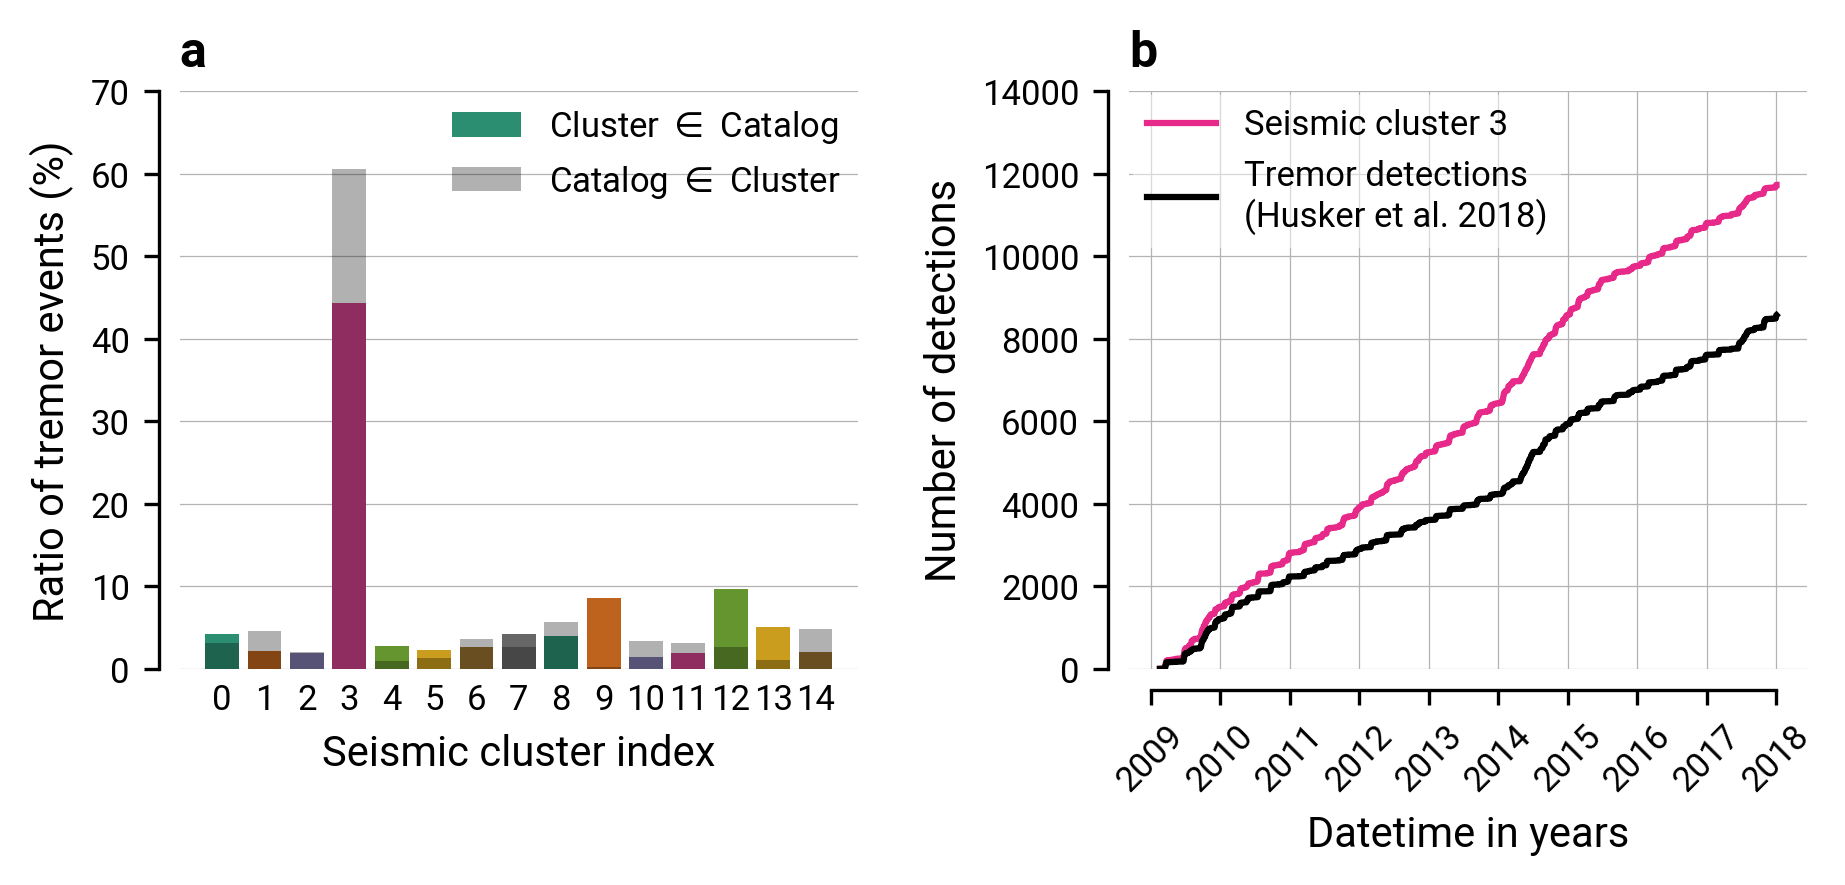

In [89]:
# Get overlap between tremor cluster and seismic clusters
cluster_distribution = data.clusters.copy().astype(bool)
for cluster_index in data.cluster:
    cluster = data.clusters.sel(cluster=cluster_index) > 0
    overlap = np.logical_and(catalog_as_cluster, cluster)
    cluster_distribution.loc[dict(cluster=cluster_index)] = overlap

# Calculate cluster events included in catalog
included = cluster_distribution.sum(dim="time")
included = included / data.clusters.sum(dim="time") * 100

# Calcuate explained ratio
explained = cluster_distribution.sum(dim="time") / catalog_as_cluster.sum()
explained *= 100

# Pick up the cluster with the highest ratio
match_index = included.cluster.values[np.argmax(included.values)]
match_cluster = data.clusters.isel(cluster=match_index).copy()

# Figure
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5), gridspec_kw=dict(wspace=0.4))

sns.barplot(x=included.cluster.values, y=included.values, palette="Dark2", ax=ax[0], label="Cluster $\in$ Catalog")
sns.barplot(x=explained.cluster.values, y=explained.values, color="k", ax=ax[0], label="Catalog $\in$ Cluster", alpha=0.3)

# Show detected matching tremor cluster
colors = sns.color_palette("Dark2", n_colors=included.shape[0])
time = match_cluster.time
ax[1].plot(time, match_cluster.cumsum(), color=colors[match_index])
ax[1].plot(time, catalog_as_cluster.cumsum(), color="k")

# Labels
ax[0].set_title("")
ax[0].set_ylabel("Ratio of tremor events (%)")
ax[0].set_xlabel("Seismic cluster index")
ax[0].set_xlim(-1, data.cluster.max() + 1)
ax[0].grid(True, axis="y")
ax[0].set_title("a", loc="left")
ax[0].legend()
ax[1].set_title("b", loc="left")
ax[1].grid(True)
ax[1].set_title("")
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel("Datetime in years")
ax[1].set_ylabel("Number of detections")
ax[1].legend(
    [
        f"Seismic cluster {match_index}",
        "Tremor detections\n(Husker et al. 2018)",
    ],
    loc="upper left",
    frameon=True,
)

# Seaborn style
sns.despine(ax=ax[0], offset=5, trim=True, bottom=True)
sns.despine(ax=ax[1], offset=5, trim=True)
ax[0].tick_params(axis="x", which="major", length=0)
ax[1].tick_params(axis="x", rotation=45)

# Save
filename = f"{DIRPATH_FIGURES}/d4_tremor_cluster_hist_{SUFFIX}.pdf"
fig.savefig(filename, bbox_inches="tight")


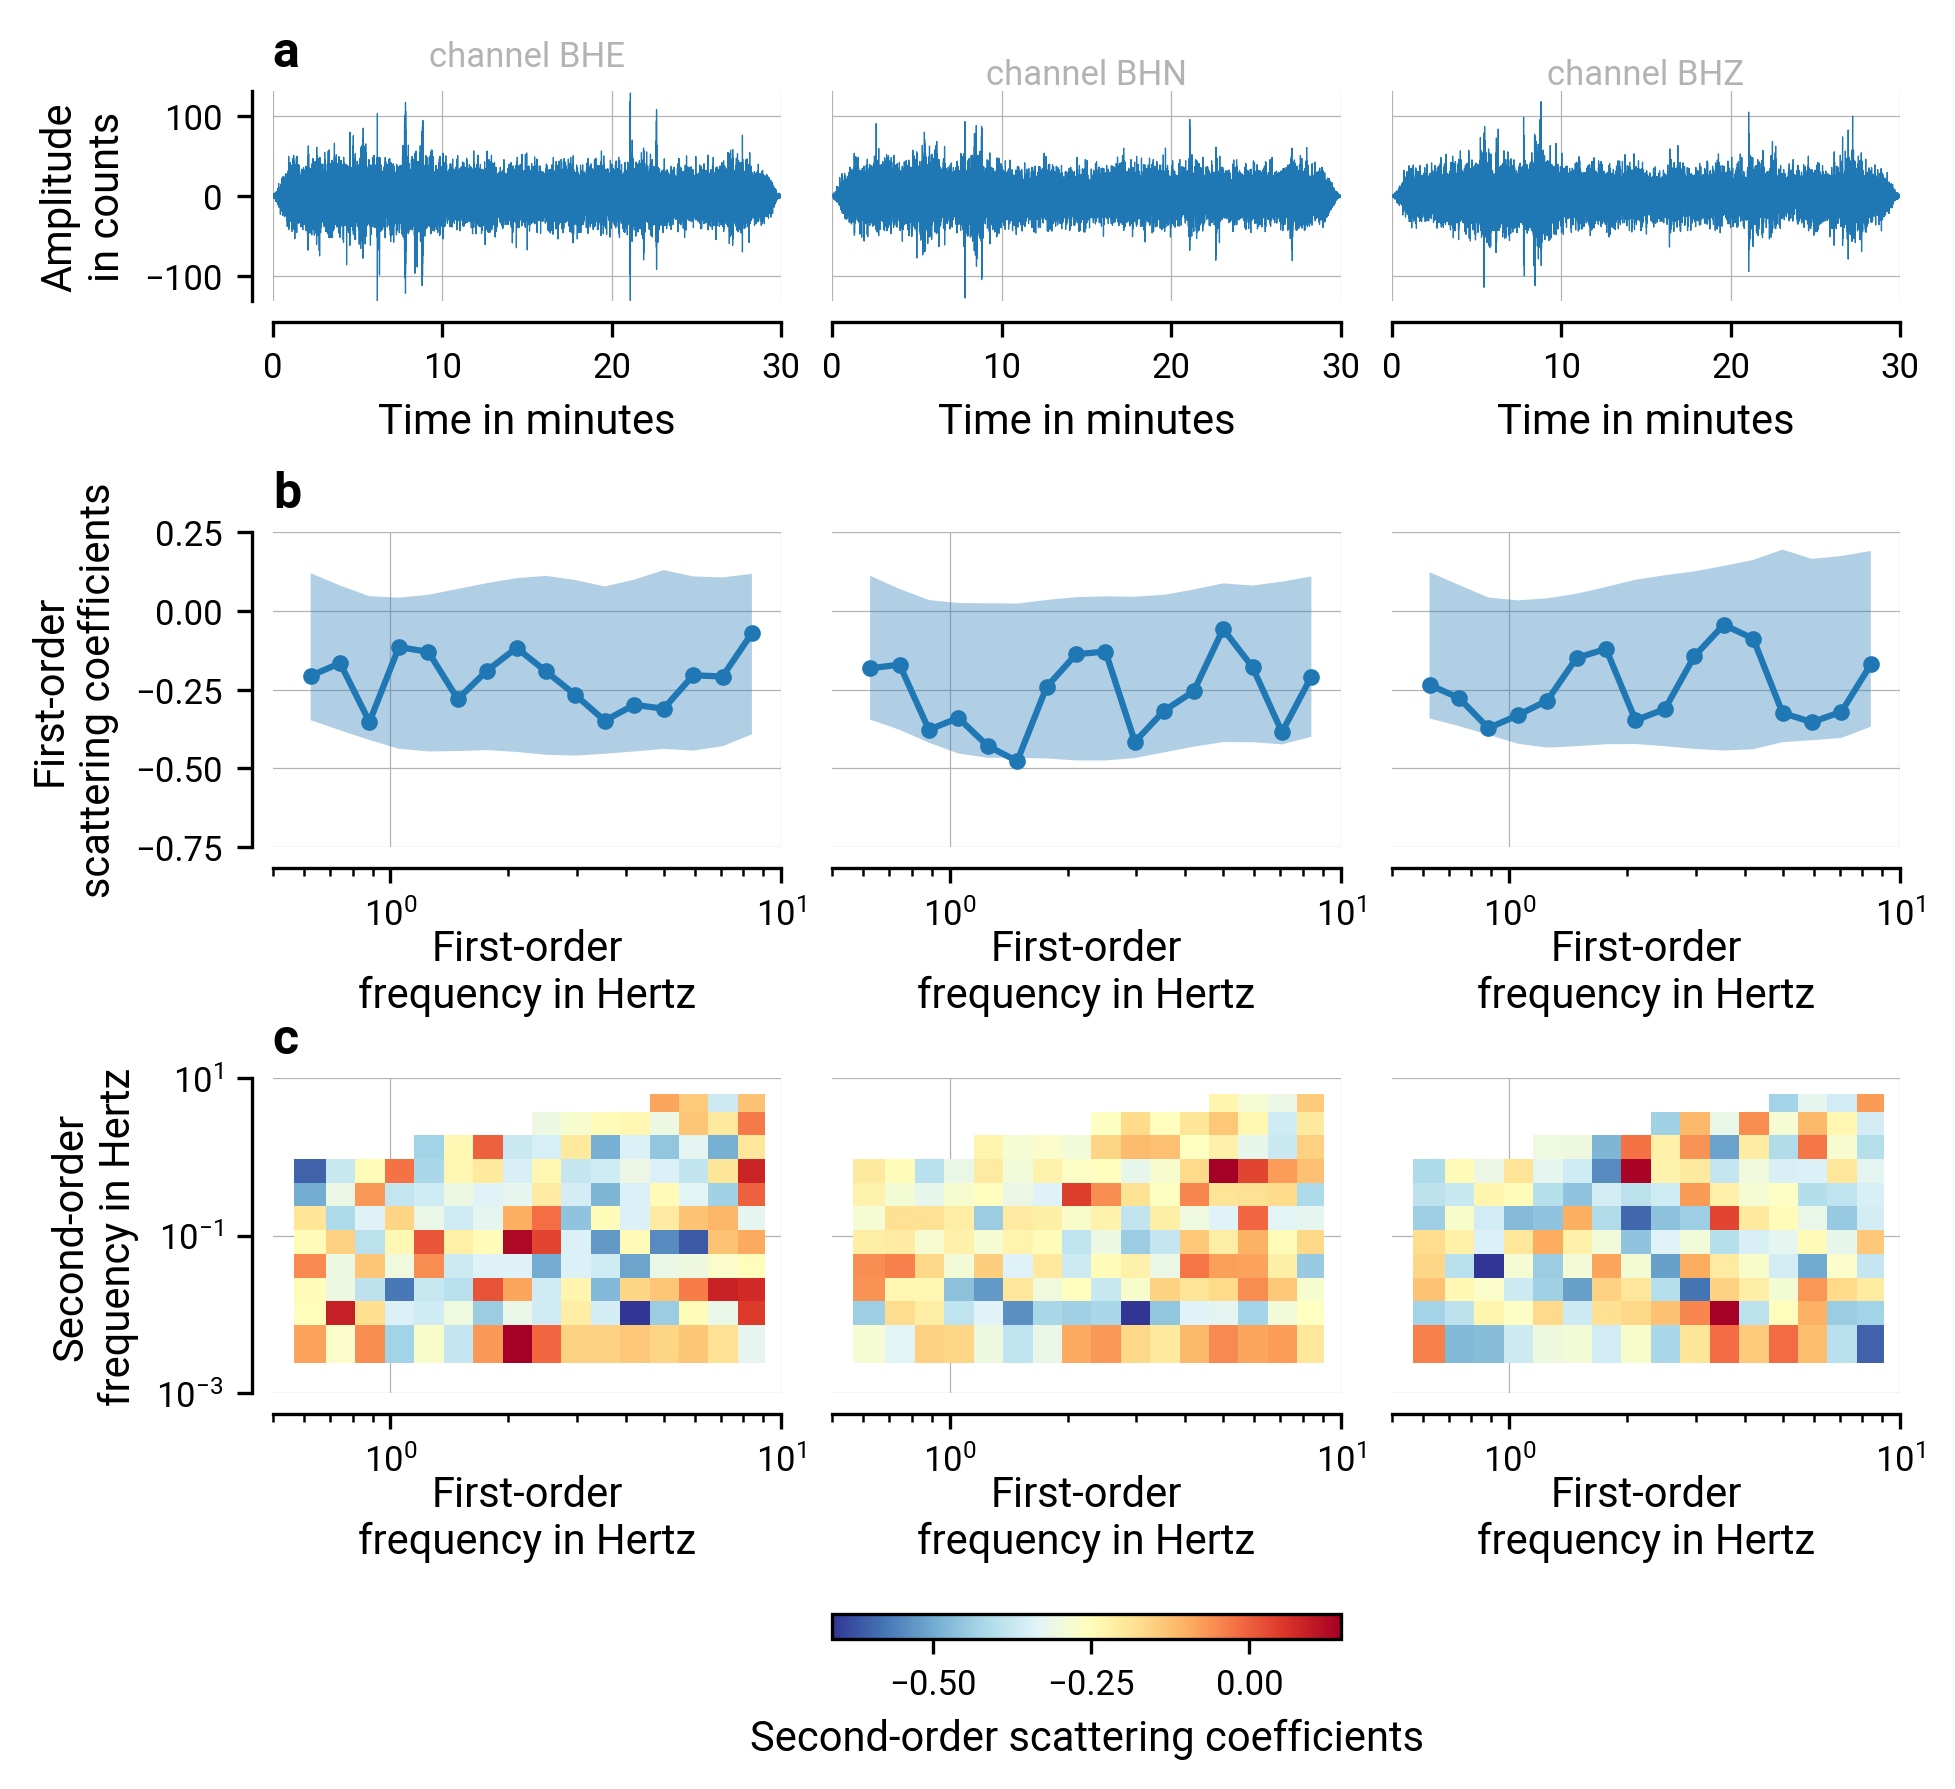

In [98]:
# Sort by distance to centroid
centroids = data.attrs["clustering"].cluster_centers_[cluster_index]
in_cluster = data.clusters.isel(cluster=cluster_index)
features_in = data.where(in_cluster, np.nan)
distances = np.linalg.norm(features_in.features - centroids[:, None], axis=0)
sorted = distances.argsort()

# Extract sample
scat_coefs = data.isel(time=sorted[0]) - data.mean(dim="time")

# Min and max attributes
# Attribute min and max
demeaned = features_in - data.mean(dim="time")
scat_coefs.attrs["order_1_minmax"] = [
    demeaned.order_1.mean(dim="time") - demeaned.order_1.std(dim="time"),
    demeaned.order_1.mean(dim="time") + demeaned.order_1.std(dim="time"),
]
scat_coefs.attrs["order_2_minmax"] = [
    demeaned.order_2.mean() - demeaned.order_2.std(),
    demeaned.order_2.mean() + demeaned.order_2.std(),
]

# Extract most representative waveform
index = int(scat_coefs.index.data)
stream = scatterings.waveforms[index]

# Show
ax = figures.show_sample(
    stream,
    scat_coefs,
    order2_kwargs=dict(cmap="RdYlBu_r"),
    trace_kwargs=dict(lw=0.3, time_factor=60, time_unit="minutes"),
)

# Save
ax[1][0].set_xlim(0.5, 10)
ax[2][0].set_xlim(0.5, 10)

# Save figure
filename = f"{DIRPATH_FIGURES}/d6_tremor_most_{SUFFIX}.pdf"
plt.savefig(filename, bbox_inches="tight")

## Model waveform

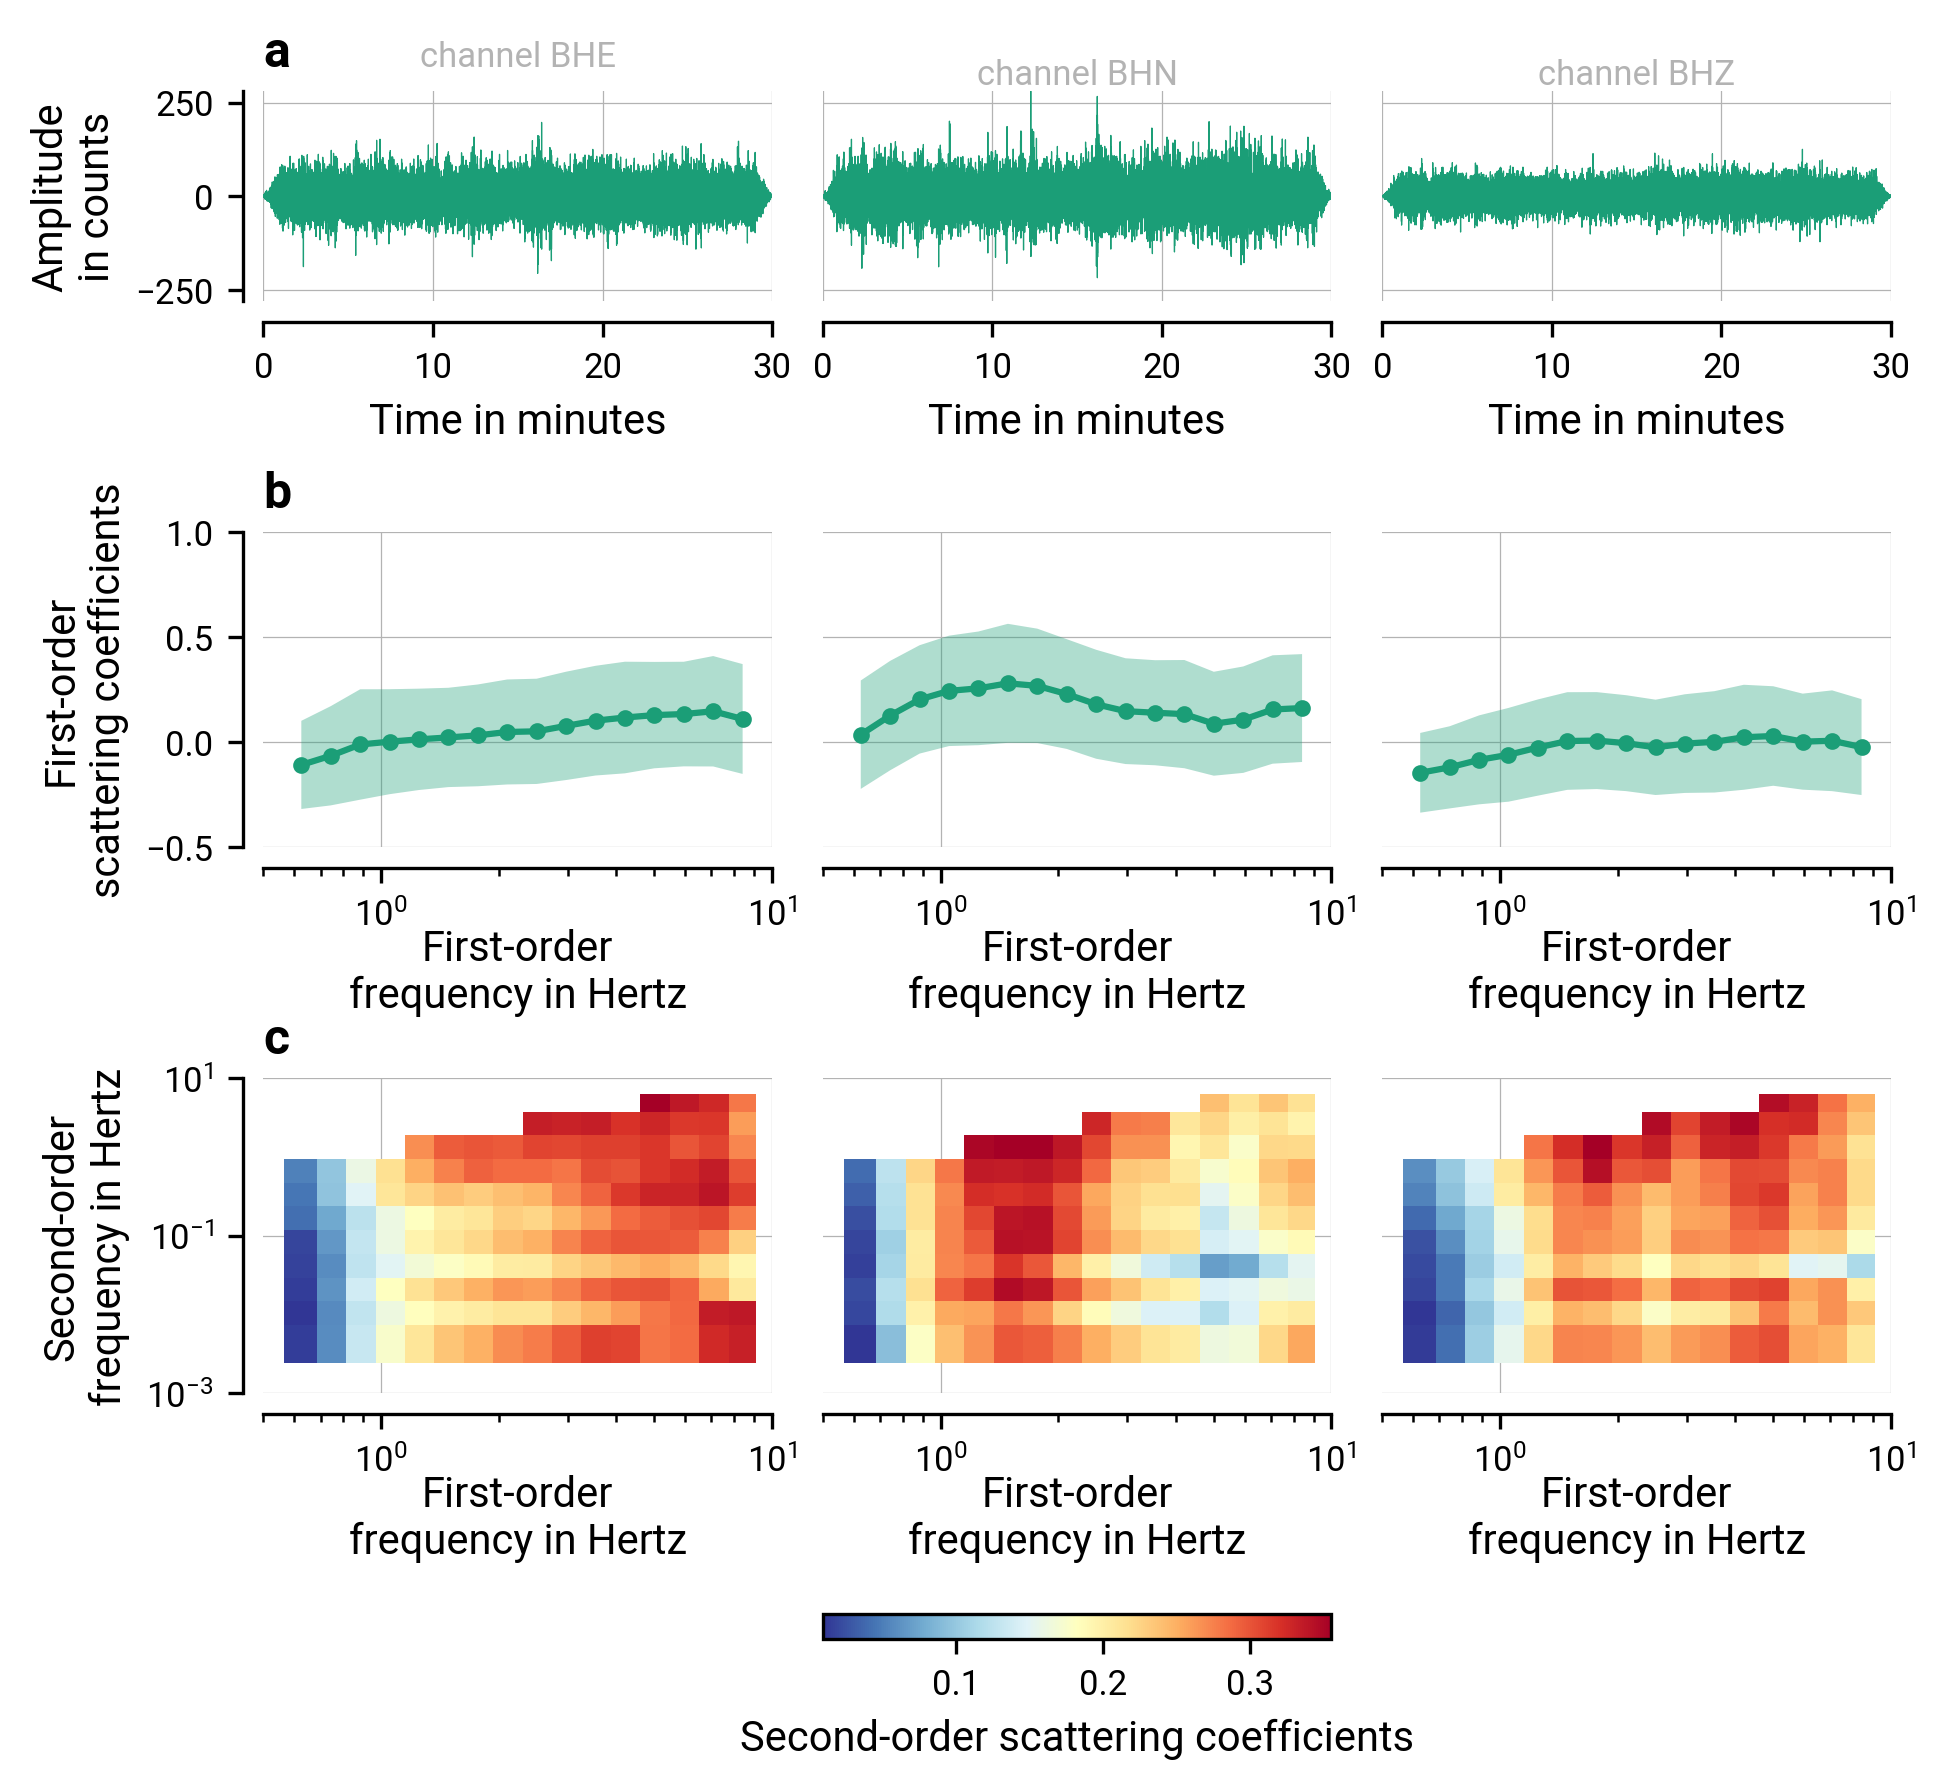

In [13]:
# Get cluster center
centroid = features.attrs["clustering"].cluster_centers_[CLUSTER_INDEX]

# Sort by distance to centroid
in_cluster = features.clusters.isel(cluster=CLUSTER_INDEX)
features_in = features.where(in_cluster, np.nan)
distances = np.linalg.norm(features_in.features - centroid[:, None], axis=0)
sorted = distances.argsort()


# Extract sample
scat_coefs = (features_in.mean(dim="time") - features.mean(dim="time")).copy()

# Min and max attributes
# Attribute min and max
demeaned = features_in - features.mean(dim="time")
scat_coefs.attrs["order_1_minmax"] = [
    demeaned.order_1.mean(dim="time") - demeaned.order_1.std(dim="time"),
    demeaned.order_1.mean(dim="time") + demeaned.order_1.std(dim="time"),
]
scat_coefs.attrs["order_2_minmax"] = [
    demeaned.order_2.mean() - demeaned.order_2.std(),
    demeaned.order_2.mean() + demeaned.order_2.std(),
]

# Extract most representative waveform
index = int(features.isel(time=sorted[0]).index.data)
stream = scatterings.waveforms[index]

# Show
# figures.show_sample(stream, scat_coefs, ylim=False, vlim=False)
sns.set_palette("Dark2")
ax = figures.show_sample(
    stream,
    scat_coefs,
    order2_kwargs=dict(cmap="RdYlBu_r"),
    trace_kwargs=dict(lw=0.3, time_factor=60, time_unit="minutes"),
)

# Beauty
ax[1][0].set_xlim(0.5, 10)
ax[2][0].set_xlim(0.5, 10)

# Show
plt.show()

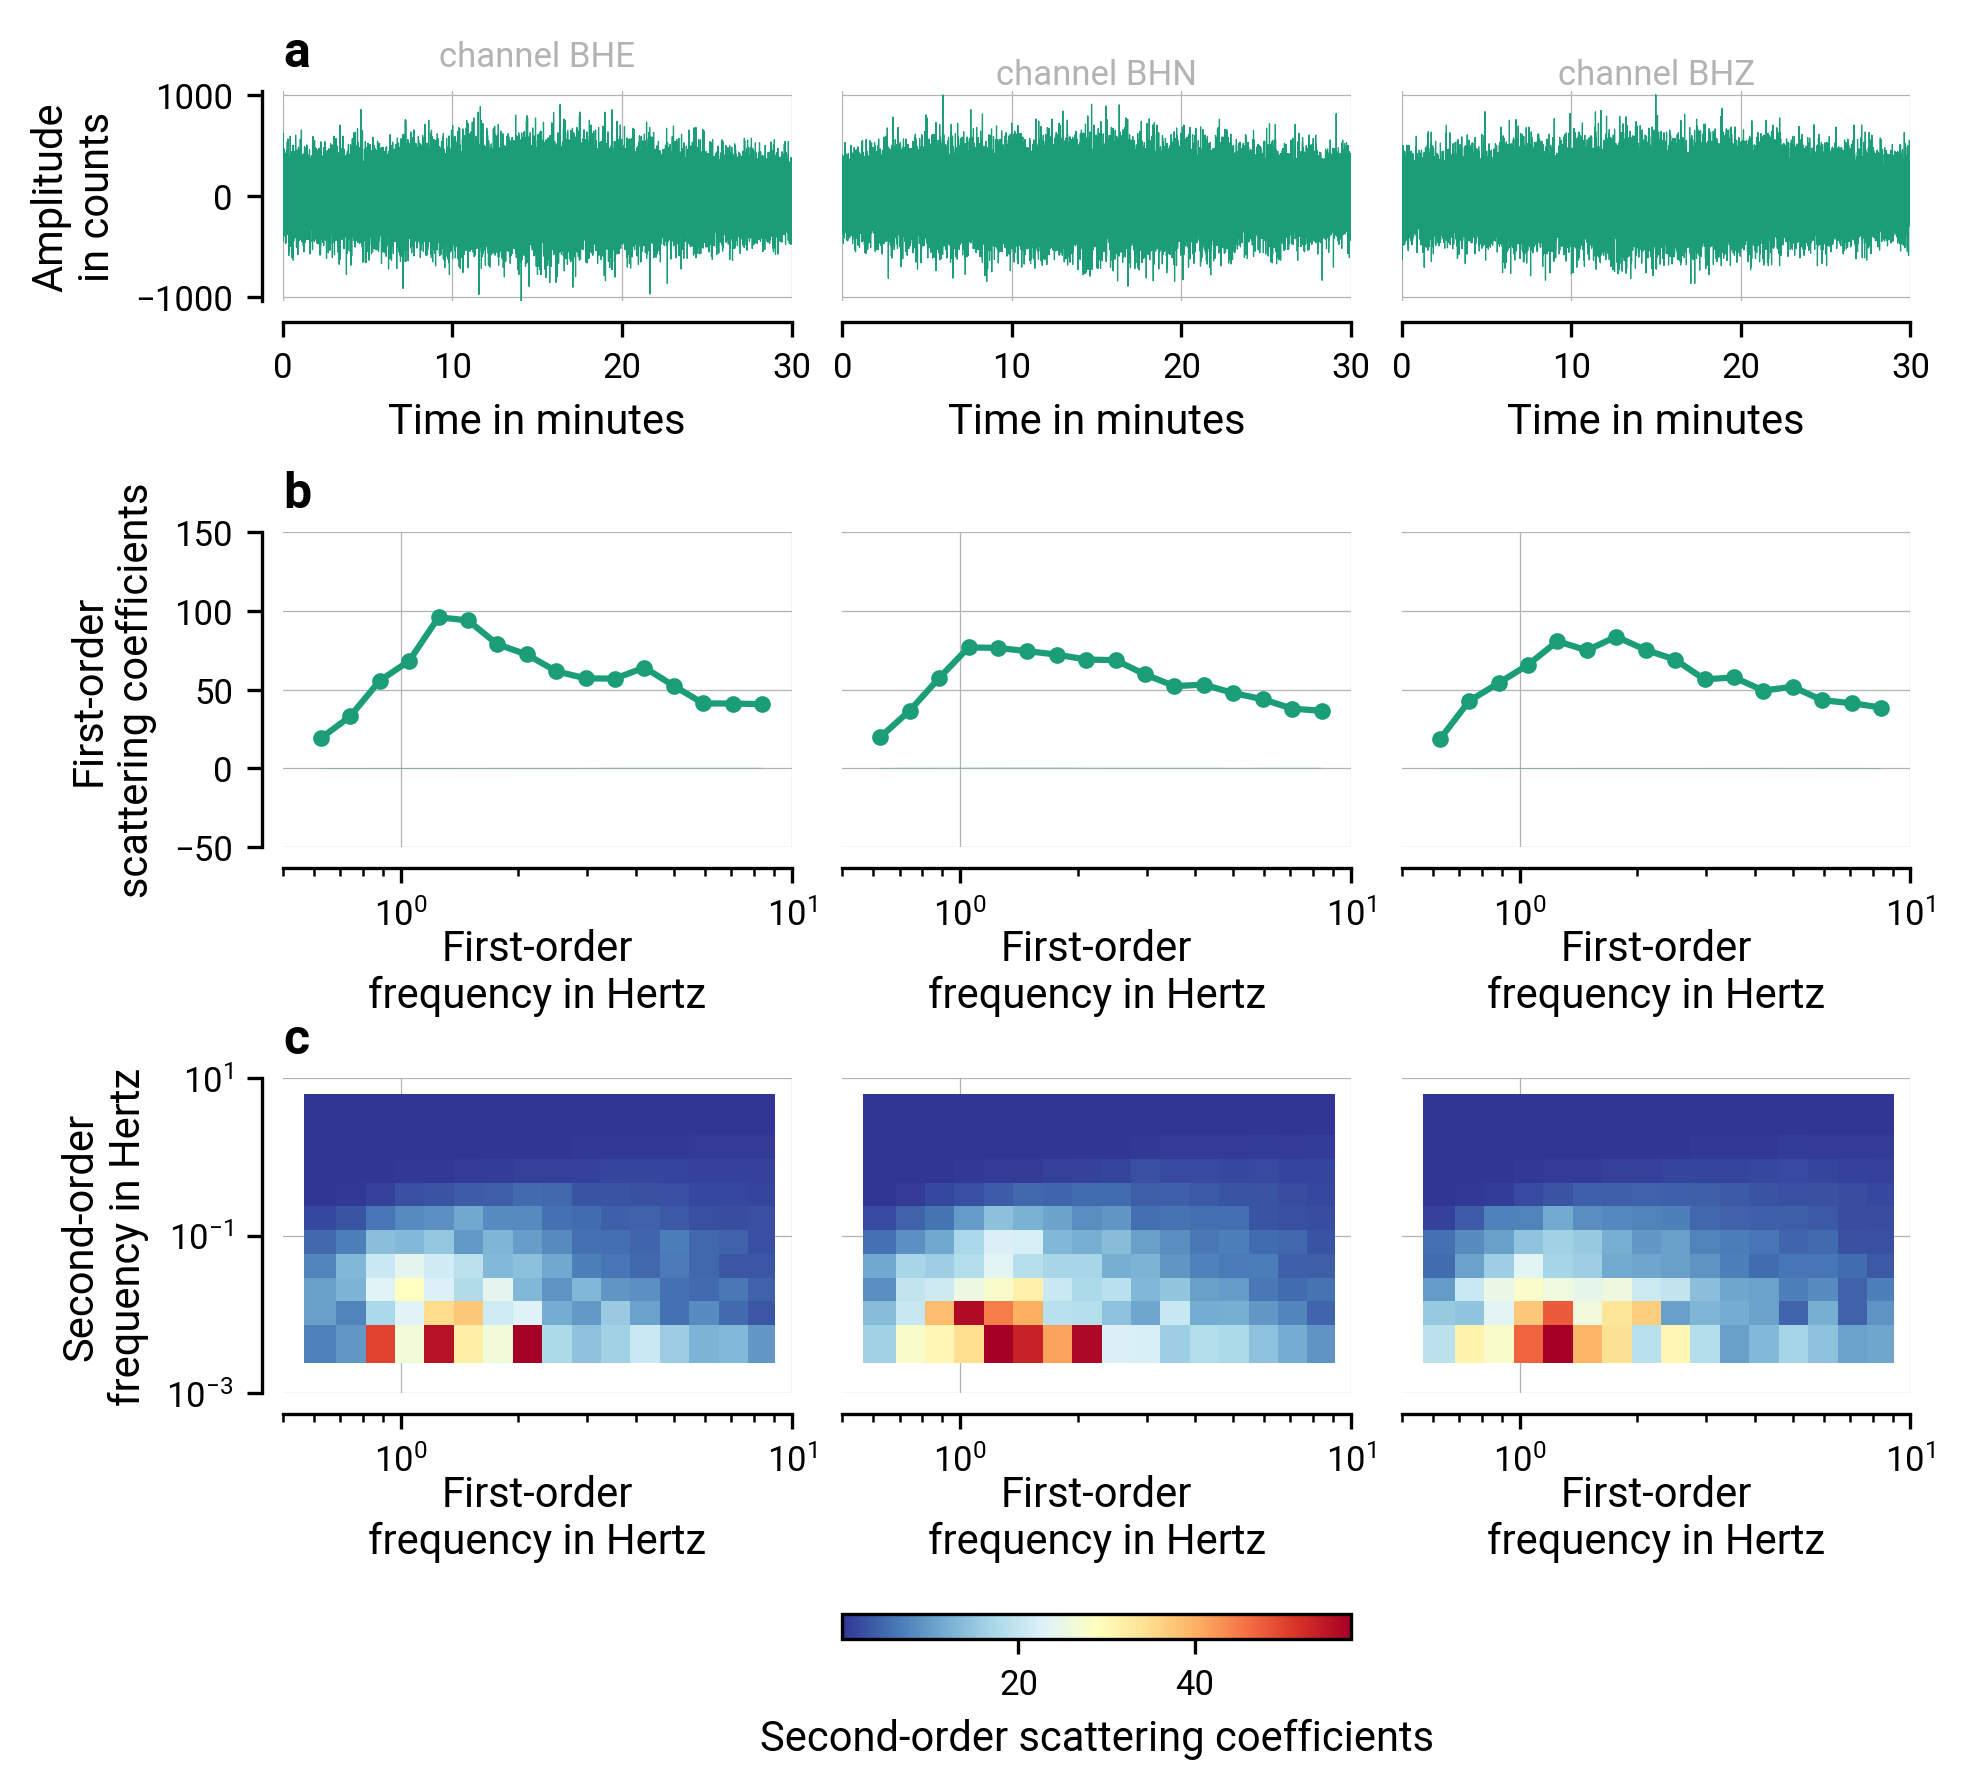

In [10]:
# Create signal
x = np.random.randn(3, scatterings.model.bins)
for index in range(3):
    x[index] = np.convolve(x[index], x[index], mode="same")

# Highpass filter
fs = scatterings.waveforms[0][0].stats.sampling_rate
sos = signal.butter(4, 1, 'hp', fs=fs, output='sos')
x = signal.sosfilt(sos, x)

# Calculate scatterings
coefs = scatterings.model.transform_sample(x, reduce_type="max")
scat_modeled = features_in.mean(dim="time").copy()

# Assign
scat_modeled.order_1.values = coefs[0] / 50
scat_modeled.order_2.values = coefs[1] / 16000

# Min and max attributes
# Attribute min and max
# scat_modeled -= features.mean(dim="time")
scat_modeled.attrs["order_1_minmax"] = scat_coefs.attrs["order_1_minmax"]

# Extract most representative waveform
index = int(features.isel(time=sorted[0]).index.data)
stream = scatterings.waveforms[index].copy()
for i, trace in enumerate(stream):
    trace.data = x[i]

# Show
# figures.show_sample(stream, scat_coefs, ylim=False, vlim=False)
sns.set_palette("Dark2")
ax = figures.show_sample(
    stream,
    scat_modeled,
    order2_kwargs=dict(cmap="RdYlBu_r"),
    trace_kwargs=dict(lw=0.3, time_factor=60, time_unit="minutes"),
)

# Beauty
ax[1][0].set_xlim(0.5, 10)
ax[2][0].set_xlim(0.5, 10)

# Show
plt.show()